# Sample Econometrics Project in GCP / Python / JupyterLab Notebooks

##### The Statsmodels module is required in order to perform econometric work in a Jupyter notebook in GCP. It is not installed by default when we set up our AI instance so we need to explicitly install it on the VM before we can instantiate any objects from the Statsmodels module library. Once we finish running the installation, we then need to manually restart the kernel in order to pick up the Statsmodels objects and begin using them. Installing Statsmodels and then rebooting the kernel is a one-time setup on the VM. Returning to the same compute VM for other work we will pick up the Statsmodels library automatically.

In [9]:
# If Statsmodels module is not installed, uncomment/run the pip install on the next line.
#pip install statsmodels --user

Note: you may need to restart the kernel to use updated packages.


## Instantiate Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms

from statsmodels.formula.api import ols
from statsmodels.compat import lzip

from statsmodels.graphics.gofplots import ProbPlot

#import pandas.tseries.api as sm
#from tseries.formula.apt import ols

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr


plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Latex markup language 
from IPython.display import Latex

## Method 1: Read in data from csv file in Google Storage
##### Note how easy it has become to read in a csv data set into a pandas dataframe from the GS Storage Buckets.

In [2]:
%%time
#df = pd.read_csv('gs://m_vrieze/data/Charity.csv',sep='|',nrows=100000)
df1 = pd.read_csv('gs://m_vrieze/data/Charity.csv',sep=',')
print(df1.head())

   OBS  RESPONSE  GIFT  RESPLASTMAIL  WEEKSLASTRESP  PROPRESPONSE  \
0    1         0     0             0     143.000000           0.3   
1    2         0     0             0      65.428571           0.3   
2    3         0     0             1      13.142857           0.3   
3    4         0     0             0     120.142857           0.3   
4    5         1    10             0     103.857143           0.2   

   MAILSPERYEAR  GIFTLASTRESP  AVERAGEGIFT  
0           2.5            10         10.0  
1           2.5            10         10.0  
2           2.5            10         10.0  
3           2.5            10         10.0  
4           2.5            10         10.0  
CPU times: user 72 ms, sys: 24 ms, total: 96 ms
Wall time: 768 ms


## Method 2: Read in the data from BigQuery table
##### Note how easy it is to read in a BigQuery table into a pandas dataframe.

In [7]:
%%time
# Import the library
from google.cloud import bigquery

# Instantiate the client
client = bigquery.Client()

#Write the query - note the ticks surrounding project.dataset.table
sql = """
SELECT * from `email-dm-optimization.Test_data.Charity`
"""

#Execute the query and set results to Pandas dataframe
df1 = client.query(sql).to_dataframe()
print(df1.head())

   OBS  RESPONSE  GIFT  RESPLASTMAIL  WEEKSLASTRESP  PROPRESPONSE  \
0  809         0     0             0          158.0         0.125   
1  810         0     0             0          158.0         0.125   
2  815         0     0             0          158.0         0.125   
3  820         0     0             0          143.0         0.125   
4  893         0     0             0          158.0         0.125   

   MAILSPERYEAR  GIFTLASTRESP  AVERAGEGIFT  
0           2.0            50         50.0  
1           2.0            50         50.0  
2           2.0            50         50.0  
3           2.0            50         50.0  
4           2.0            71         71.0  
CPU times: user 120 ms, sys: 20 ms, total: 140 ms
Wall time: 1.68 s


In [3]:
df1=df1.set_index('OBS')
df1['constant'] = 1

In [4]:
%%time
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4268 entries, 1 to 4268
Data columns (total 9 columns):
RESPONSE         4268 non-null int64
GIFT             4268 non-null int64
RESPLASTMAIL     4268 non-null int64
WEEKSLASTRESP    4268 non-null float64
PROPRESPONSE     4268 non-null float64
MAILSPERYEAR     4268 non-null float64
GIFTLASTRESP     4268 non-null int64
AVERAGEGIFT      4268 non-null float64
constant         4268 non-null int64
dtypes: float64(4), int64(5)
memory usage: 333.4 KB
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 7.06 ms


# Data Explorations - Histograms

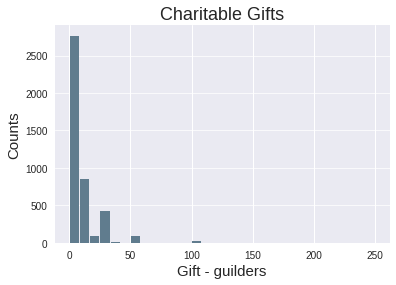

In [6]:
#hist_series = pd.Series(df1.salary)
#hist_series.plot.hist(grid=True, bins=10, rwidth=0.9, color='#607c8e')
df1.GIFT.plot.hist(grid=True, bins=30, rwidth=0.9, color='#607c8e')
plt.title('Charitable Gifts')
plt.xlabel('Gift - guilders')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# Textbook Questions

##### Question i. What is the average gift? What Percentage gave no gift?

In [9]:
mean_gift = np.mean(df1['AVERAGEGIFT'])
print('The mean gift amount is: $' + str(mean_gift) )
#print(mean_gift)

The mean gift amount is: $18.24283716433107


In [10]:
# Note how we use the constant variable
count_all = np.sum(df1['constant'])

# Filter to determine $0 donors
df2 = df1[df1['GIFT'] == 0]
count_zero = np.sum(df2['constant'])

print('The total count of potential donors is: ' + str(count_all))
print('The total count of $0 donors is: ' + str(count_zero))
pct_zero = (count_zero / count_all)*100
print('The percentage giving no gift at all is: ' + str(pct_zero) + '%')

The total count of potential donors is: 4268
The total count of $0 donors is: 2561
The percentage giving no gift at all is: 60.00468603561387%


##### Question ii. What is the average mailings per year?  What are the MIN and MAX number of mailings?

In [11]:
# Use numpy functions
mean_mailings = np.mean(df1['MAILSPERYEAR'])
min_mailings = np.min(df1['MAILSPERYEAR'])
max_mailings = np.max(df1['MAILSPERYEAR'])
print('The mean number of mailings per year is: ' + str(mean_mailings))
print('The min number of mailings per year is: ' + str(min_mailings))
print('The max number of mailings per year is: ' + str(max_mailings))

The mean number of mailings per year is: 2.0495548266166823
The min number of mailings per year is: 0.25
The max number of mailings per year is: 3.5


##### Question iii: Estimate the model: $gift = \alpha + \beta_{1} mailsyear + \mu$ 
##### (Latex markup cheatsheet can be found at https://wch.github.io/latexsheet/)

In [10]:
formula = '''GIFT ~ (MAILSPERYEAR)
'''
#model = ols(formula, df).fit(cov_type='HC0')
model = ols(formula, df1)
results = model.fit()
aov_table = statsmodels.stats.anova.anova_lm(results, typ=2)
print('The Analysis of Variance (ANOVA) Table:')
print(aov_table)
print(' ')
print(' ')
print('The Model Estimation results:')
print(results.summary())

The Analysis of Variance (ANOVA) Table:
                     sum_sq      df         F        PR(>F)
MAILSPERYEAR   13349.725136     1.0  59.64904  1.403549e-14
Residual      954750.114367  4266.0       NaN           NaN
 
 
The Model Estimation results:
                            OLS Regression Results                            
Dep. Variable:                   GIFT   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     59.65
Date:                Tue, 07 Jan 2020   Prob (F-statistic):           1.40e-14
Time:                        02:47:16   Log-Likelihood:                -17602.
No. Observations:                4268   AIC:                         3.521e+04
Df Residuals:                    4266   BIC:                         3.522e+04
Df Model:                           1                                         
Covariance Type:            nonrobu

##### Question v. What is the smallest predicted contribution in the sample?

- fitted values (need a constant term for intercept)

In [11]:
model_fitted_y = results.fittedvalues
min_fitted_y = np.min(model_fitted_y)
print(min_fitted_y)

2.676466398185669


# Residual Plots
- Note: we need some helper variables from the regresstion results

In [20]:
# fitted values (need a constant term for intercept)
model_fitted_y = results.fittedvalues

# model residuals
model_residuals = results.resid

# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]

### Residual Plot
- a non-linear plot line is indicative of non-linear relationship not captured in model

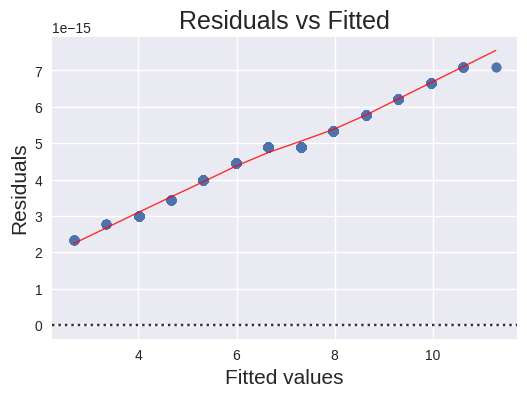

In [21]:
plot_lm_1 = plt.figure(1, figsize=(6, 4), frameon=False, dpi=100)
plot_lm_1.set_figheight(4)
plot_lm_1.set_figwidth(6)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'MAILSPERYEAR', data=df1, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]),clip_on=True);

### QQ Plot
- residuals following plot line well indicative of normally distributed residuals
- residuals that deviate sharply indicative of non-normally distributed residuals

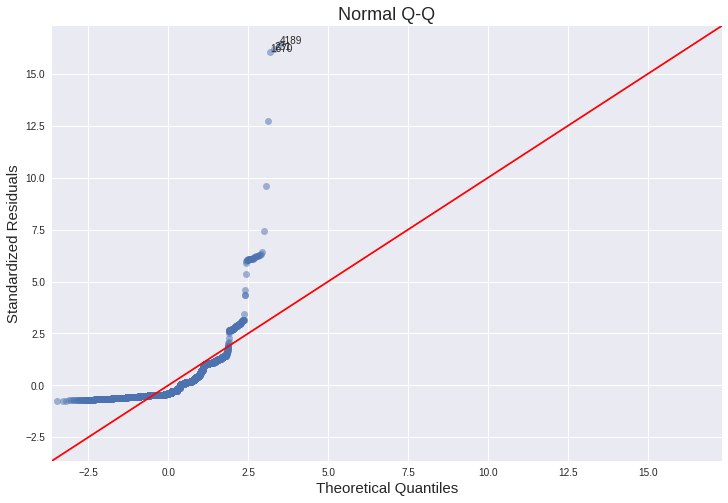

In [22]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

# Scale Location Plot
## indicative of homoscedastic residuals
- Good to see even spread with horizontal line
- Bad to see sloped line with spread following a pattern

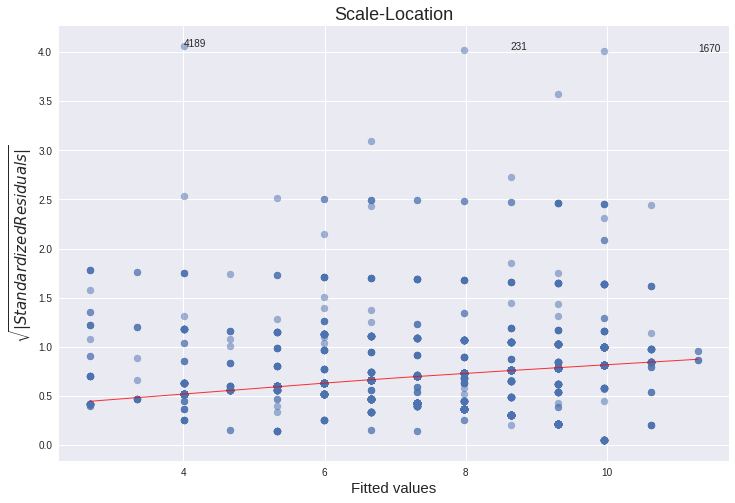

In [23]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

# Leverage Plot
## helps us find influential cases (outliers)

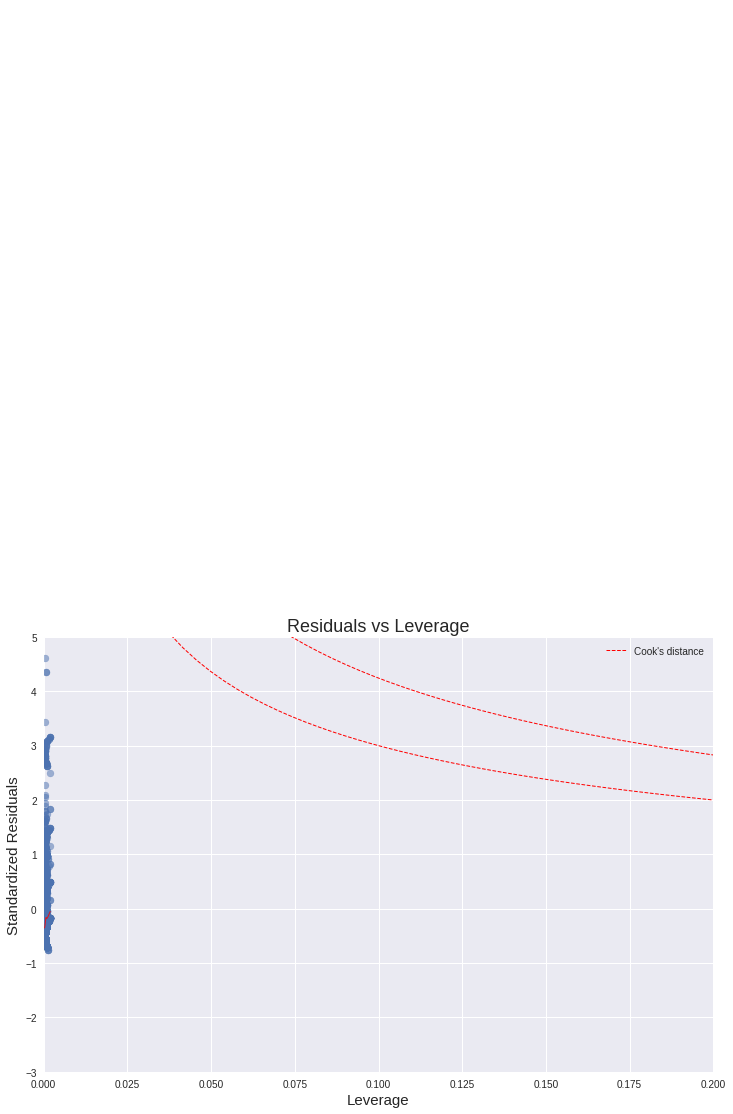

In [24]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(results.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

# Explicit Tests for Heteroscedasticity
### Breusch-Pagan Test - p-value < 0.05 ==> evidence of heteroscedasticity

In [25]:
print("Heteroscedasticity Test - Breusch Pagan")
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

Heteroscedasticity Test - Breusch Pagan


[('Lagrange multiplier statistic', 2.1416105378326105),
 ('p-value', 0.1433513269232418),
 ('f-value', 2.141681631289713),
 ('f p-value', 0.14341835908696376)]

### Goldfeld Quandt Test - p-value < 0.05 ==> evidence of heteroscedasticity

In [26]:
print("Heteroscedasticity Test - Goldfeld Quandt")
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
lzip(name, test)

Heteroscedasticity Test - Goldfeld Quandt


[('F statistic', 0.5476337132863057), ('p-value', 0.9999999999999999)]